# Jaccard Sim between Inputs and Whole brain
1. Filter both dataframes for the overlapping neurons (exist in both datasets)
    
    a. We are comparing the coarse modules of one connectome to all the resolutions of the other connectome

2. Adjust jaccard similarity functions to be able to pull from two data frames to create the zero and new set. These functions were written and tested in the jaccardsim_analysis.ipynb file
3. Analyze the inputs and WB data against eachother

Written By Rhessa Weber Langstaff working with Dr. Gabrielle J Gutierrez and collaborating with Alex Kunin

In [2]:
# Import partition data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Pull in whole brain data
wbs = pd.read_csv('hemibrain/preprocessed-v1.2/preprocessed_nodes.csv', index_col=0)

## Filter wholebrain and input dataframe for the neurons that are in both datasets

In [4]:
# Dataframes for the Combined data
df_in = pd.read_csv('oviIN_combined/preprocessed_inputs-v1.2.1/preprocessed_nodes.csv', index_col=0)

# Define BodyIds from the inputs
ids = df_in.index.values

# Filter the wb data to only include the bodyIds from the inputs
wb = wbs[wbs.index.isin(ids)]

# Filter the input data to only include the overlapping bodyIds
df_in_filtered = df_in[df_in.index.isin(wb.index.values)]

## Function to compare to two datasets interchangeably

In [43]:
# create a function that takes in two lists of id numbers and returns the jaccard sim of the two lists
def calculate_difference(list1, list2):
    set1 = set(list1)
    set2 = set(list2)

    unique_1 = set1-set2
    unique_2 = set2-set1

    # Union of set1 and set 2
    union_1_2 = set1 | set2
    common = set1.intersection(set2)

    # calculate Jaccard similarity
    jaccard_sim = len(common) / len(union_1_2)

    return unique_1, unique_2, common, jaccard_sim

# function that takes in a partition dataframe, the modules at the base resolution, and the chi value at which to compare
def get_body_ids(df, coarse_modules, chi):
    """ This function takes in a partition dataframe, the modules at the base resolution, and the chi value at which to compare. 
    It returns a dictionary of body IDs for each cluster number at the resolution and a dictionary of body IDs for each cluster 
    number at the base resolution."""

    # Gets cluster numbers for resolution
    chi_values = [chi]
    cluster_all = np.zeros((len(coarse_modules),len(chi_values), 800))
    for i, x in enumerate(coarse_modules):
        df_test = df[df['0.0']==x]
        for f, y in enumerate(chi_values):
            cluster = df_test[y].unique()
            cluster_all[i,f, :len(cluster)] = cluster

    # move everything to a dictionary
    dict = {}
    for i, x in enumerate(coarse_modules):
        dict[coarse_modules[i]] = cluster_all[i,0]
    
    # Remove the zeros from the array
    for key, value in dict.items():
        dict[key] = value[value != 0]
        dict[key] = np.array(value, dtype='int64')
    
    # Get bodyIDs for each cluster number in the resolution
    dict_new = dict.fromkeys(coarse_modules, [])
    for key, value in dict.items():
        body_ids = []
        for i, x in enumerate(value):
            body_ids.extend(df[df[chi]==x].index.tolist())
        dict_new[key] = body_ids

    return dict_new

# Function returns the zero set of the dataframe given
def get_zero_set(df, zero_modules):
    # Need bodyIds at zero resolution for each cluster number
    # create an empty dict using modules list given (zero_modules) as keys and empty lists as values
    dict_zero= dict.fromkeys(zero_modules, [])
    for key, value in dict_zero.items():
        dict_zero[key] = df[df['0.0']==key].index.tolist()
    return dict_zero
    
# Function that takes in partition dataframe, the modules at the base resolution, and the chi value at which to compare
def main_jaccard(df_zero, df, zero_modules, reg_modules, chi):
    """ This function takes in a partition dataframe, the modules at the base resolution, and the chi 
    value at which to compare. It returns a dataframe of the jaccard similarities between the resolutions at each cluster"""

    # Get the body IDs for each cluster number at the resolution and the base resolution
    dict_new = get_body_ids(df, reg_modules, chi)
    dict_zero = get_zero_set(df_zero, zero_modules)

    # Create a dictionary to store the jaccard similarities
    jaccard_dict = {}
    for key, value in dict_new.items():
        jaccard_dict[key] = []
        unique_1, unique_2, common, jaccard_sim = calculate_difference(dict_new[key], dict_zero[key])
        jaccard_dict[key].append(jaccard_sim)
    
    # Create a dataframe to store the jaccard similarities
    df_jaccard = pd.DataFrame(jaccard_dict)
    df_jaccard.index = np.arange(1, len(df_jaccard)+1)
    
    return df_jaccard

# Main function for the full process of jaccard similarity
def run_jaccard(chi_vals, zero_mods, coarse_modules, df_zero, df_change, title, x_label):
    """ This function takes in a list of chi values, the modules at the base resolution, and the chi value at which to compare. 
    It returns a dataframe of the jaccard similarities between the resolutions at each cluster"""

    # Create a dataframe to store the jaccard similarities
    df_jaccard = pd.DataFrame(index=np.arange(1, len(chi_vals)+1), columns=coarse_modules)

    # Loop through the chi values and calculate the jaccard similarities
    for i, chi in enumerate(chi_vals):
        df_jaccard.loc[i+1] = main_jaccard(df_zero, df_change, zero_mods, coarse_modules, chi).values
    
    # Add in the mean similarity over all chi values
    df_jaccard['mean'] = df_jaccard.mean(axis=1)

    # Transpose and rename columns to match the chi values
    df_jaccard = df_jaccard.T
    df_jaccard.columns = chi_vals

    fig, ax  = plt.subplots()
    for i in range(0, len(zero_mods)):
        ax.plot(df_jaccard.columns, df_jaccard.iloc[i], marker='o', label=f'Cluster {i+1}')

    # Plot mean
    ax.plot(df_jaccard.columns, df_jaccard.iloc[len(zero_mods)], linestyle = "--", label='Mean', color='grey')

    ax.set_ylim(0, 1.0)
    ax.legend()
    ax.set_ylabel('Jaccard Similarity')
    ax.set_xlabel(x_label)
    ax.set_title(title)
    return df_jaccard

### Comparing combined data to WB 

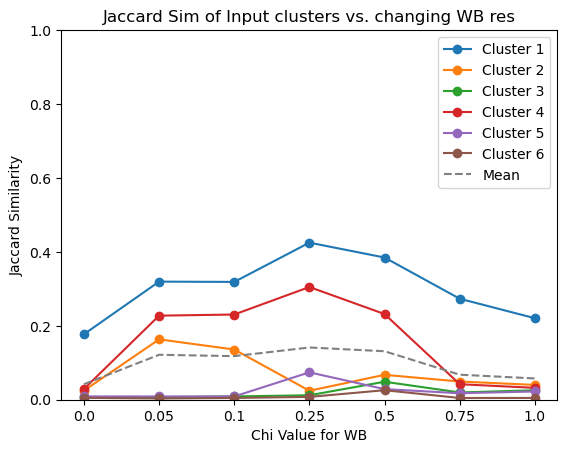

In [44]:
# Running jaccard similarity for each chi value
coarse_modules = [1, 2, 3, 4, 5, 6]
zero_mods = [1, 2, 3, 4, 5, 6]
chi_vals = ['0.0', '0.05', '0.1', '0.25', '0.5', '0.75', '1.0']
jaccard_dict = run_jaccard(chi_vals, zero_mods, coarse_modules, df_in_filtered, wb, title='Jaccard Sim of Input clusters vs. changing WB res', x_label='Chi Value for WB')

In [6]:
jaccard_dict

,0.0,0.05,0.1,0.25,0.5,0.75,1.0
1,0.177232,0.31952,0.318753,0.424977,0.384768,0.273256,0.220537
2,0.024624,0.163342,0.135829,0.024259,0.067371,0.049268,0.040053
3,0.007063,0.007059,0.00892,0.01206,0.048622,0.019691,0.025627
4,0.028953,0.227448,0.230515,0.304933,0.231788,0.042017,0.03212
5,0.008929,0.008889,0.008889,0.074074,0.028646,0.017544,0.022321
6,0.005102,0.003373,0.004785,0.007619,0.025765,0.004684,0.004831


### Findings for combined oviIN coarse modules compared against WB resolutions
We see cluster 1 and 4 overlapping the most with the whole brain resolution 0.25. Cluster 2 shows the most overlap at 0.5 and then decreases to low similarity.

### Comparing oviINr input coarse modules to changing WB resolutions

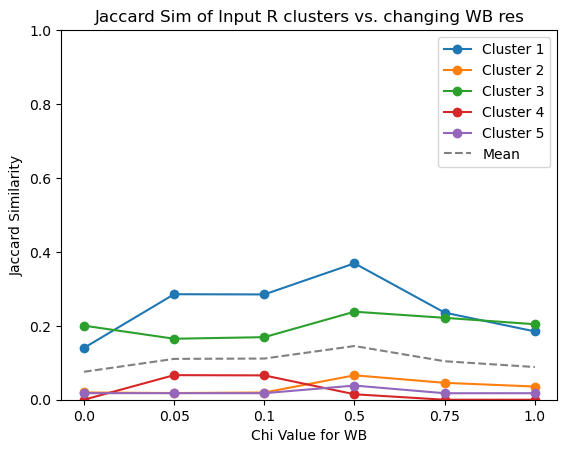

In [45]:
# Following the same process for just the right oviIN data
df_inr = pd.read_csv('oviIN/preprocessed_inputs-v1.2.1/preprocessed_nodes.csv', index_col=0)
wbs = pd.read_csv('hemibrain/preprocessed-v1.2/preprocessed_nodes.csv', index_col=0)

# bodyIds from the inputs
ids = df_inr.index.values

# Filter the wb data to only include the bodyIds from the inputs
wb = wbs[wbs.index.isin(ids)]

# Filtered inputs
df_in_filteredr = df_inr[df_inr.index.isin(wb.index.values)]

# Running jaccard similarity
coarse_modules = [1, 2, 3, 4, 5]
zero_mods = [1, 2, 3, 4, 5]
chi_vals = ['0.0', '0.05', '0.1', '0.5', '0.75', '1.0']
jaccard_dictr = run_jaccard(chi_vals, zero_mods, coarse_modules, df_in_filteredr, wb, title='Jaccard Sim of Input R clusters vs. changing WB res', x_label='Chi Value for WB')


### Comparing the WB coarse modules to the changing input resolutions

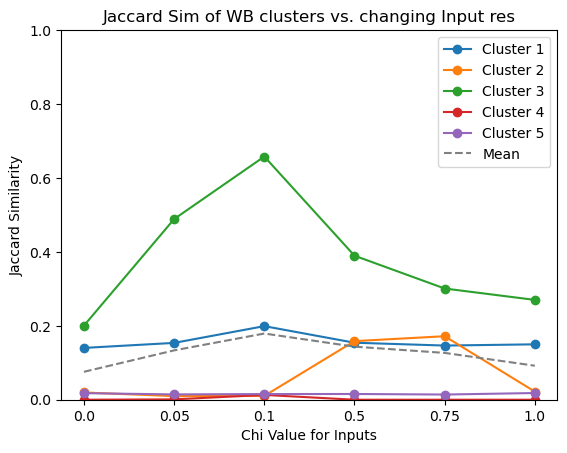

In [46]:
# Doing it the other way (Inputs as zero set and WB resolution changing)
df_inr = pd.read_csv('oviIN/preprocessed_inputs-v1.2.1/preprocessed_nodes.csv', index_col=0)
wbs = pd.read_csv('hemibrain/preprocessed-v1.2/preprocessed_nodes.csv', index_col=0)
# bodyIds from the inputs
ids = df_inr.index.values

# Filter the wb data to only include the bodyIds from the inputs
wb = wbs[wbs.index.isin(ids)]

# Filtered inputs
df_in_filteredr = df_inr[df_inr.index.isin(wb.index.values)]

# Running jaccard
coarse_modules = [1, 2, 3, 4, 5]
zero_mods = [1, 2, 3, 4, 5]
chi_vals = ['0.0', '0.05', '0.1', '0.5', '0.75', '1.0']
jaccard_dictr = run_jaccard(chi_vals, zero_mods, coarse_modules, wb, df_in_filteredr, title='Jaccard Sim of WB clusters vs. changing Input res', x_label='Chi Value for Inputs')

# Documentation of findings
In this notebook I compared the Whole brain modularity data against the Input connectome of the oviIN_r neuron and the Input connectome of the combined oviIN connectome. Focusing in on the right oviIN connectome figures, I made sure to only use the overlapping neurons that exist in both the oviINr modularity data and the hemibrain dataset. 

The first plot is the coarse modules (modules at 0.0) of the oviINr input connectome compared against the modules in all resolutions of the wholebrain.  
- Here I noticed that input cluster 1 overlaps the most with WB modularity at resolution 0.5. 
- Input cluster 3 also shows the most overlap with WB modularity at resolution 0.5

The second plot is the coarse modules (at 0.0) of the whole brain connectome compared against the modules in all resolutions of the input connectome
- Here cluster 3 of the whole brain overlaps the most with input modularity at resolution 0.1
- Cluster 1 shows steady similarity throughout all resolutions of the input connectome, showing the most at 0.1 as well
- Cluster 2 here shows very low similarity until resolution 0.5 and 0.75 before decreasing again

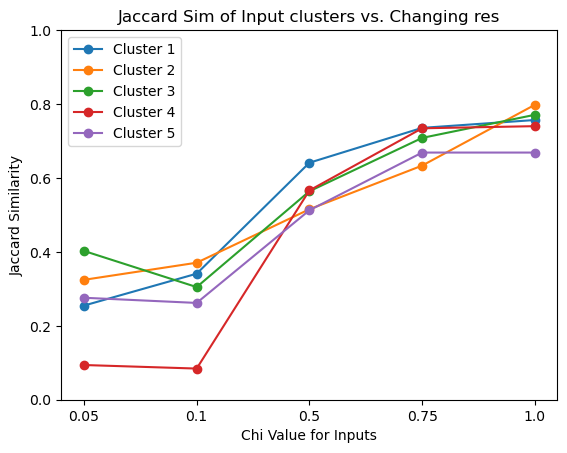

In [13]:
chi_vals = ['0.05', '0.1', '0.5', '0.75', '1.0']
jaccard_dictr = run_jaccard(chi_vals, zero_mods, coarse_modules, df_in_filteredr, df_in_filteredr, title='Jaccard Sim of Input clusters vs. Changing res', x_label='Chi Value for Inputs')